# Summary of this notebook

In this notebook, we experiment with selecting features (words) based on their *frequency ratio*: (word's frequency in Class 1 corpus)/(word's frequency in Class 0 corpus).  The work is incomplete, but much of the idea behind this technique can be understood from the early steps taken in the notebook.

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import itertools

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction import text
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

#Import functions and preprocessors from previous notebook
from processing_functions import url_preprocessor, stem_processor

## Data Import

In [2]:
df_all = pd.read_csv('../data/combined.csv', index_col='id')

#Since Pandas converts empty strings to NaN's, we need to fill these in again
df_all.fillna('', inplace=True)
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2325 entries, 107hfj5 to 10b33q8
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   title        2325 non-null   object 
 1   text         2325 non-null   object 
 2   utc          2325 non-null   float64
 3   subreddit    2325 non-null   object 
 4   title_words  2325 non-null   int64  
 5   text_words   2325 non-null   int64  
 6   title_chars  2325 non-null   int64  
 7   text_chars   2325 non-null   int64  
dtypes: float64(1), int64(4), object(3)
memory usage: 163.5+ KB


## Train/Test Split

We reserve 25% of our data in the dataframe `val_df`.  The remaining 75% of the data will be used to train our models; we will store this data in the dataframe `df`.  We will not use the `val_df` data until the validation stage at the end of the modeling process.

In [3]:
df, val_df = train_test_split(df_all,
                               random_state=123,
                               stratify=df_all['subreddit'])
df['subreddit'].value_counts()

Producers    930
Composers    813
Name: subreddit, dtype: int64

## Baseline accuracy

In [4]:
df['subreddit'].value_counts(normalize=True)

Producers    0.533563
Composers    0.466437
Name: subreddit, dtype: float64

So if we used a null model that just guessed the most common class ("Producers") in all cases, our accuracy score would be about 53.3%.

## Words that strongly signal one subreddit over the other: An example

Here, we pick up the idea mentioned at the end of the [last notebook](./03_EDA.ipynb).  After applying a `CountVectorizer` to the various titles of posts, we want to see which words are much *more common* among one subreddit or the other.  However, we need to take measures to avoid erroneously concluding that a word that appears only a very small number of times (say, only in the Producers data set) is a strong signal of one particular subreddit, when in reality it is simply a rare word but potentially equally likely to appear in either subreddit.  We can achieve this by setting the `min_df` hyperparameter of `CountVectorizer` large enough to avoid all incredibly rare words.  After doing so, for each remaining word that appears in the title of any post in either subreddit, we can construct the ratio

`freq_ratio` = **(Frequency of word in Composers subreddit without `min_df`) / (Frequency of word in Producers subreddit without `min_df`)**.

If this ratio is very large (and certainly if it is infinity), then seeing this word in the title of a post is a strong indicator that the post came from the Composers subreddit.  Conversely, if this ratio is very small (and certainly if it is zero), then seeing this word in the title of a post is a strong indicator that the post came from the Producers subreddit.

To optimally incorporate this idea into our modeling, we'll want to perform a grid search for the best hyperparameters (such as `min_df`, whether to use titles only or also body texts, and what kind of preprocessing to do).  However, to understand this method before grid searching, we'll try one example using some "reasonable" values of the hyperparameters.  Specifically, for now we will:
- Use only the titles of posts and look only at single words (no bigrams etc.).
- Preprocess using the `url_preprocessor` (but not the `stem_processor`) from the last notebook.
- Set a `min_df` value of .01, meaning that any word in consideration must appear in the title of at least 1% of posts (in the subreddit from which it came) in order to be considered.

In [5]:
comps = df[df['subreddit']=='Composers']
comps.head(2)

,title,text,utc,subreddit,title_words,text_words,title_chars,text_chars
id,,,,,,,,
zoda66,"First Composition, what do you think ?","Hi. I'm new into music, I tried to compose som...",1.671303e+09,Composers,8,68,38,437
10axn2g,Tiki Taki - a piece in 15/8 time,"I think this really swings, in a circular sort...",1.673625e+09,Composers,8,56,32,460


In [6]:
prods = df[df['subreddit']=='Producers']
prods.head(2)

,title,text,utc,subreddit,title_words,text_words,title_chars,text_chars
id,,,,,,,,
103osx2,halftime vs gross beat,is there any audible difference between using ...,1.672891e+09,Producers,4,30,22,159
zznfx9,How do you achieve this synth sound?,"In Redveil's song ""2daside"", what synth is use...",1.672468e+09,Producers,8,28,36,134


In [7]:
#Make dataframes of wordcounts in titles of posts

#Transformer that vounts all words, regardless of frequency
cv_all = CountVectorizer(stop_words = stopwords.words('english'),
                     preprocessor= lambda x : url_preprocessor(x))

#Transformer that counts only those words that appear in at least 1% of titles
cv_top = CountVectorizer(stop_words = stopwords.words('english'),
                     preprocessor= lambda x : url_preprocessor(x),
                     min_df = .01)

comps_top_words = cv_top.fit_transform(comps['title'])
comps_top_words_df = pd.DataFrame(comps_top_words.todense(), columns=cv_top.get_feature_names_out(), index=comps.index)

prods_top_words = cv_top.fit_transform(prods['title'])
prods_top_words_df = pd.DataFrame(prods_top_words.todense(), columns=cv_top.get_feature_names_out(), index=prods.index)

comps_all_words = cv_all.fit_transform(comps['title'])
comps_all_words_df = pd.DataFrame(comps_all_words.todense(), columns=cv_all.get_feature_names_out(), index=comps.index)

prods_all_words = cv_all.fit_transform(prods['title'])
prods_all_words_df = pd.DataFrame(prods_all_words.todense(), columns=cv_all.get_feature_names_out(), index=prods.index)

In [8]:
#What are the words that appear in at least 1% of titles of posts in "Composers"?
comps_top_words_df.columns

Index(['anyone', 'audio', 'band', 'best', 'chord', 'classical', 'compose',
       'composer', 'composers', 'composing', 'composition', 'concerto',
       'favorite', 'feedback', 'film', 'first', 'flute', 'free', 'fugue',
       'get', 'good', 'guitar', 'help', 'inspired', 'instruments', 'know',
       'like', 'little', 'looking', 'love', 'major', 'make', 'melody', 'minor',
       'movement', 'musescore', 'music', 'need', 'new', 'notation', 'one',
       'orchestra', 'orchestral', 'original', 'piano', 'piece', 'please',
       'prelude', 'quartet', 'question', 'quintet', 'score', 'scores', 'short',
       'software', 'solo', 'sonata', 'song', 'string', 'style', 'symphony',
       'theme', 'think', 'time', 'two', 'use', 'video', 'violin', 'wind',
       'work', 'would', 'write', 'writing', 'wrote'],
      dtype='object')

In [9]:
#What are the words that appear in at least 1% of titles of posts in "Producers"?
prods_top_words_df.columns

Index(['ableton', 'advice', 'anyone', 'artists', 'audio', 'bass', 'beat',
       'beats', 'beginner', 'best', 'create', 'daw', 'drum', 'drums', 'effect',
       'find', 'first', 'fl', 'free', 'get', 'good', 'got', 'guitar',
       'headphones', 'help', 'instruments', 'interface', 'key', 'keyboard',
       'know', 'laptop', 'learn', 'like', 'live', 'logic', 'looking', 'made',
       'make', 'making', 'mic', 'midi', 'mix', 'mixing', 'music', 'need',
       'new', 'one', 'piano', 'please', 'plugin', 'plugins', 'pro', 'producer',
       'producers', 'production', 'question', 'record', 'recording', 'sample',
       'samples', 'software', 'someone', 'song', 'songs', 'sound', 'sounds',
       'start', 'studio', 'synth', 'think', 'time', 'tips', 'track', 'trying',
       'type', 'use', 'used', 'using', 'vocal', 'vocals', 'voice', 'vs', 'vst',
       'want', 'way', 'work', 'worth', 'would'],
      dtype='object')

Notice that these two sets of "words that appear in at least 1% of titles" have almost no overlap!  If we were, for each word in these lists, to simply define `freq_ratio` to be the ratio of its frequency in "Composers" posts to its frequency in "Producers" posts, the we would find that the `freq_ratio` of almost all of these words is either 0 or infinity.  This would give us no meaningful way to distinguish which of these "strong indicators of one subreddit over the other" is a *stronger* indicator than many of its peers.

To fix this, we will calculate frequencies among the `comps_all_words_df` and `prods_all_words_df` - those dataframes that contain *all* the words that appear in any titles - rather than among merely the `comps_top_words_df` and `prods_top_words_df`.

In [10]:
words_to_check = set(list(comps_top_words_df.columns) + list(prods_top_words_df.columns))

words = []
freq_ratios = []

for word in words_to_check:
    #If the word only appears in the Producers data (not in Composers), set freq_ratio=0
    if word not in comps_all_words_df.columns:
        freq_ratio = 0
        
    #If the word only appears in the Composers data (not in Producers), set freq_ratio=infinity
    elif word not in prods_all_words_df.columns:
        freq_ratio = np.inf
    
    #If the word appears in both, take the ratio of frequencies
    else:
        comps_freq = comps_all_words_df.sum()[word]/len(comps)
        prods_freq = prods_all_words_df.sum()[word]/len(prods)
        freq_ratio = comps_freq / prods_freq
    
    words.append(word)
    freq_ratios.append(freq_ratio)
    

In [11]:
freq_ratios_df = pd.DataFrame(freq_ratios, index=words)
freq_ratios_df.columns = ['freq_ratio']
len(freq_ratios_df)

134

So 134 words appear in at least 1% of Producers titles *or* in at least 1% of Composers titles.  Among these words, which are the strongest indicators of each subreddit?

#### Words most strongly indicating "Composers"

In [12]:
#Examine the 25 words that have the highest frequency ratio,
#i.e. the strongest indicators of "Composers" subreddit
freq_ratios_df.sort_values('freq_ratio', ascending=False).head(25)

,freq_ratio
minor,inf
composer,inf
fugue,inf
prelude,inf
piece,inf
composition,inf
theme,inf
quintet,inf
flute,inf
concerto,inf


#### Words most strongly indicating "Producers"

In [13]:
#Examine the 25 words that have the lowest frequency ratio,
#i.e. the strongest indicators of "Producers" subreddit
freq_ratios_df.sort_values('freq_ratio', ascending=False).tail(25)

,freq_ratio
producers,0.067289
sample,0.063551
vocal,0.060206
synth,0.057196
beats,0.045756
midi,0.038130
mixing,0.000000
samples,0.000000
beat,0.000000
logic,0.000000


## Plots of top words with nonzero, non-infinite frequency ratios

In [14]:
nonzero_freqs = freq_ratios_df[(freq_ratios_df['freq_ratio'] !=0) & (freq_ratios_df['freq_ratio'] != np.inf)].sort_values('freq_ratio')

In [15]:
nonzero_freqs['prods_freq_ratio'] = nonzero_freqs['freq_ratio'].map(lambda x : 1/x)
nonzero_freqs['comps_freq_ratio'] = nonzero_freqs['freq_ratio']

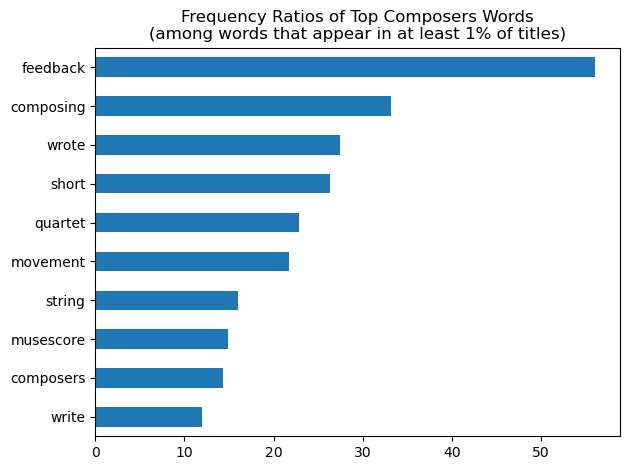

In [16]:
nonzero_freqs["comps_freq_ratio"].tail(10).plot(kind='barh',
                                                title='Frequency Ratios of Top Composers Words\n(among words that appear in at least 1% of titles)')
plt.tight_layout();
plt.savefig(f'../images/freq_ratio_comps_top_words.png');

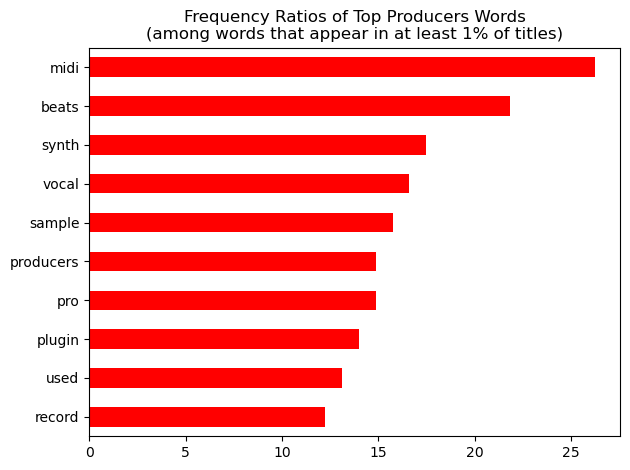

In [51]:
nonzero_freqs["prods_freq_ratio"].head(10).plot(kind='barh',
                                                title='Frequency Ratios of Top Producers Words\n(among words that appear in at least 1% of titles)',
                                               color='r')
plt.gca().invert_yaxis()
plt.tight_layout();
plt.savefig(f'../images/freq_ratio_prods_top_words.png');

## Analysis of Top Words by Frequency Ratio

Judging by my basic knowledge of music composition and production, the first "top 25" list above *does* seem to contain mostly words that I would strongly associate with Composition over Production.  Similarly, the second list seems to contain mostly words that I would strongly associate with Production over Composition.  However, there are certainly some surprising exceptions, such as "love" and "feedback" in the first list and "got" in the second list.  This does not mean that these words are poor predictors, though - it's quite possible that e.g. the two subreddits have different cultures, making the word "love" much more common in one than the other.

If a word in a post's title appears near the top (bottom) of the sorted list of 134 words - of which we saw the top and bottom 25 words - then that post is very likely to have come from the Composers (Producers) subreddit.  However, it is certainly not the case that all posts have one of these words in their titles.  For now, we can ask: of all the posts from either subreddit, how many contain a word in the top or bottom ~25% (top/bottom 34 words out of all 134) of the sorted list?

In [18]:
words = freq_ratios_df.index
#Top and bottom ~25.4% of the lists above
tops = list(freq_ratios_df.sort_values('freq_ratio', ascending=False).head(34).index)
bots = list(freq_ratios_df.sort_values('freq_ratio', ascending=False).tail(34).index)

results=[]
for ind in df.index:
    flag=0
    for word in tops + bots:
        if word in df.loc[ind, 'title']:
            flag=1
            break
    if flag==1:
        results.append(1)
    else:
        results.append(0)

#Compute the proportion of posts whose titles contain one of these "top" or "bottom" words
res = pd.Series(results)
res.mean()

0.4991394148020654

This means that just about half of all posts contain one of the words ("top" or "bottom" words) that strongly indicate one subreddit or another.  The other half of words do not give us such strong information about the subreddit from which they might have come.  A rough guess thus tells us that a model trained only on the titles of posts, and given access to the word counts only of the 134 words above, would probably classify about 75% of posts correctly.  This assumes the model will automatically be correct about any posts containing a "top" or "bottom" word in its title, and it will have to guess completely at random in all other cases; obviously this is just an approximation.

To see how well such a basic model can perform, we will train a logistic regression model on nothing but the word counts of these 134 in the titles of posts.  

In [19]:
#Make a dataframe of just the 134 top words
top_words_df = pd.concat([comps_top_words_df, prods_top_words_df])

#Add back the classes to which each observation belongs
top_words_df['subreddit'] = df['subreddit']

top_words_df

,anyone,audio,band,best,chord,classical,compose,composer,composers,composing,...,using,vocal,vocals,voice,vs,vst,want,way,worth,subreddit
id,,,,,,,,,,,,,,,,,,,,,
zoda66,0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Composers
10axn2g,0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Composers
xwnm20,0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Composers
zyd8hh,0,0,0.0,2,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Composers
y03hjd,0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Composers
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10azzqv,0,0,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Producers
109519w,0,0,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Producers
zvii8w,1,0,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Producers


As we can see, there are `NaN` values in this table corresponding to words that only appear in at least 1% of "Composers" titles but not at least 1% of "Producers" titles, and vice-versa.  This means that the proper word count for each of these `NaN` values is simply zero.  So we'll fill in these missing values before proceeding:

In [20]:
top_words_df.fillna(0, inplace=True)
top_words_df.head()

,anyone,audio,band,best,chord,classical,compose,composer,composers,composing,...,using,vocal,vocals,voice,vs,vst,want,way,worth,subreddit
id,,,,,,,,,,,,,,,,,,,,,
zoda66,0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Composers
10axn2g,0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Composers
xwnm20,0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Composers
zyd8hh,0,0,0.0,2,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Composers
y03hjd,0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Composers


Lastly, we'll want to check that the words have been properly count vectorized.  To do so, let's look at the title text of the first two posts in the `top_words_df` above as well as the word counts that appear in `top_words_df` for that post.

In [21]:
ind = 'zoda66'
print(df.loc[ind,:]['title'])
[(top_words_df.loc[ind,:][i], i) for i in top_words_df.loc[ind,:].index if top_words_df.loc[ind,:][i] != 0.0 and i!='subreddit']

First Composition, what do you think ?


[(1.0, 'composition'), (1, 'first'), (1, 'think')]

In [22]:
ind = '10axn2g'
print(df.loc[ind,:]['title'])
[(top_words_df.loc[ind,:][i], i) for i in top_words_df.loc[ind,:].index if top_words_df.loc[ind,:][i] != 0.0 and i!='subreddit']

Tiki Taki - a piece in 15/8 time


[(1.0, 'piece'), (1, 'time')]

#### Gridsearch for basic logistic regression model

In [23]:
X = top_words_df.drop(columns='subreddit')
y = top_words_df['subreddit']

In [24]:
lr_pipe = Pipeline([
    ('ss', StandardScaler()),
    ('lr', LogisticRegression())
])

In [25]:
lr_pipe_params = {
    'lr__C' : np.logspace(-3,3,60)
}

In [26]:
lr_grid = GridSearchCV(lr_pipe, lr_pipe_params, n_jobs=-1)

In [27]:
lr_grid.fit(X, y)

GridSearchCV(estimator=Pipeline(steps=[('ss', StandardScaler()),
                                       ('lr', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'lr__C': array([1.00000000e-03, 1.26384820e-03, 1.59731228e-03, 2.01876025e-03,
       2.55140652e-03, 3.22459055e-03, 4.07539297e-03, 5.15067808e-03,
       6.50967523e-03, 8.22724134e-03, 1.03979842e-02, 1.31414736e-02,
       1.66088278e-02, 2.09910372e-02, 2.65294846...
       4.58159767e+00, 5.79044398e+00, 7.31824222e+00, 9.24914728e+00,
       1.16895182e+01, 1.47737765e+01, 1.86718109e+01, 2.35983347e+01,
       2.98247129e+01, 3.76939098e+01, 4.76393801e+01, 6.02089449e+01,
       7.60949669e+01, 9.61724871e+01, 1.21547425e+02, 1.53617495e+02,
       1.94149195e+02, 2.45375111e+02, 3.10116893e+02, 3.91940677e+02,
       4.95353521e+02, 6.26051657e+02, 7.91234262e+02, 1.00000000e+03])})

In [28]:
lr_grid.best_score_

0.8450894180416956

This model made use only of the words in the titles of posts.  Furthermore, it did not acutally use the frequency ratios for feature selection! The only feature selection was the `min_df=.01` parameter of `CountVectorizer`.

## Function to extract words with highest and lowest frequency ratios

In [29]:
def fr_transform(X, y, text_labels=None, cutoff_freq_ratio=0.0, cutoff_proportion=1.0, cvec_kwargs={}):
    '''
    NOTE: X and y MUST have a matching Pandas index!  Otherwise this function won't run properly.
    
    Inputs:
    -A Pandas dataframe X of texts (possibly multiple columns of text in each row of X)
    -A Pandas series y of exactly TWO classes to which each observation belongs
    -A dictionary text_labels whose keys are the names of the various columns of text in X
        and whose values are the names we'd like them to be called in the outputted 
        dataframe's columns.  For example, 
            {'title':'t', 'text':'b'}).
        We count-vectorize the words in the columns separately; e.g. if the "title" is
        'hello world' and the "text" is 'hello happy world' then the resulting columns
        will look like t_hello, t_world, b_hello, b_happy, and b_world (using the example
        dictionary above).
        If no text_labels dictionary is passed, then the columns' separate texts will simply
        be treated as parts of one big text: only one word count will be given for each word,
        rather than a separate word count for each type (column) of text.
        THIS FEATURE STILL NEEDS TO BE IMPLEMENTED.  For now, you cannot pass this argument.
    
    Parameters:
    -cutoff_freq_ratio (float, default 0): After finding the frequency ratio of each word,
        keep that word in the outputted dataframe only if its frequency ratio (or the inverse
        of its frequency ratio) is at least cutoff_freq_ratio.  For example, setting this to
        10 means only those words that are at least 10 times as common in one class as compared
        to the other will be kept in the resulting dataframe.
    -cutoff_proportion (float, default 1): After finding all frequency ratios and sorting the
        words by frequency ratio, keep only those words that appear in the top or bottom 
        cutoff_proportion proportion of this list.  For example, if cutoff_proportion=.25,
        then only the top quarter and bottom quarter of the sorted list will be kept.
    -cvec_kwargs: A dictionary of keyword arugments to be passed to CountVectorizer during
        the processing.  For example, you can specify stop_words or min_df here, as well
        as any custom preprocessing.
        
    Output:
    Separately count-vectorizes the text(s) in each of the two classes.  For each word, calculates
    the frequency of that word in each class.  Then takes the ratio of these frequencies for each word
    (in each text type, if text_labels are passed) among the two classes.  Then returns a combined
    dataframe of the count vectorizations, keeping only those words that meet the cutoff_freq_ratio
    or cutoff_proportion (if given).
    Here "words" can also mean n-grams, if an appropriate ngram_range is passed to cvec_kwargs.
    '''
    
    #Raise errors if given bad inputs
    if type(X) == pd.core.series.Series:
        raise ValueError("X must be a Pandas dataframe, not a series")
    
    if len(y.unique()) != 2:
        raise ValueError("y variable does not have exactly 2 values so can't be used for classification")
        
    if cutoff_freq_ratio > 0.0 and cutoff_proportion < .5:
        raise ValueError("You can specify AT MOST ONE of cutoff_freq_ratio or cutoff_proportion")
        
    if text_labels != None:
        if set(text_labels.keys()) != set(X.columns):
            raise ValueError("The keys of text_labels must match the names of the columns in X")
            
    
    #Make a column that concatenates (with spaces) the texts of all the text columns
    #This will be useful in case text_labels is not given
    X['%combined%']=X.apply((lambda x : ' '.join(x)), axis=1)
    
    #Split data by classes
    classes = list(y.unique())
    class0 = classes[0]
    class1 = classes[1]
    
    #Make dataframes of X separately for each class
    c0 = X[y==class0]
    c1 = X[y==class1]
    
    
    #Make vectorizers of all words (cv_all), or just words with a certain min_df, max_df, etc. (cv_top)
    problem_kws = {'min_df', 'max_df', 'max_features'}
    all_args_dict = {key:value for (key, value) in cvec_kwargs.items() if key not in problem_kws}
    top_args_dict = cvec_kwargs
    
    cv_all = CountVectorizer(**all_args_dict)
    cv_top = CountVectorizer(**top_args_dict)
    
    #Find word counts
    
    
    #IF text_labels WERE NOT GIVEN:
    #Use the '%combined%' column
    if text_labels==None:

        #Make dataframes
        c0_top_words = cv_top.fit_transform(c0['%combined%'])
        c0_top_words_df = pd.DataFrame(c0_top_words.todense(), columns=cv_top.get_feature_names_out(), index=c0.index)
    
        c1_top_words = cv_top.fit_transform(c1['%combined%'])
        c1_top_words_df = pd.DataFrame(c1_top_words.todense(), columns=cv_top.get_feature_names_out(), index=c1.index)
        
        c0_all_words = cv_all.fit_transform(c0['%combined%'])
        c0_all_words_df = pd.DataFrame(c0_all_words.todense(), columns=cv_all.get_feature_names_out(), index=c0.index)
    
        c1_all_words = cv_all.fit_transform(c1['%combined%'])
        c1_all_words_df = pd.DataFrame(c1_all_words.todense(), columns=cv_all.get_feature_names_out(), index=c1.index)
        
        #Find frequencies
        words_to_check = set(list(c0_top_words_df.columns) + list(c1_top_words_df.columns))

        words = []
        freq_ratios = []

        #Loop over each word to find its frequency
        for word in words_to_check:
            #If the word only appears in the c1 data (not in c0), set freq_ratio=0
            if word not in c0_all_words_df.columns:
                freq_ratio = 0
        
            #If the word only appears in the c0 data (not in c1), set freq_ratio=infinity
            elif word not in c1_all_words_df.columns:
                freq_ratio = np.inf
    
            #If the word appears in both, take the ratio of frequencies
            else:
                c0_freq = c0_all_words_df.sum()[word]/len(c0)
                c1_freq = c1_all_words_df.sum()[word]/len(c1)
                freq_ratio = c0_freq / c1_freq
    
            words.append(word)
            freq_ratios.append(freq_ratio)
        
        #Make frequency ratios into a dataframe indexed by the words
        freq_ratios_df = pd.DataFrame(freq_ratios, index=words)
        freq_ratios_df.columns = ['freq_ratio']
        
        

        #Remove words that don't meet the specified cutoff
        #1: cutoff_freq_ratio
        if cutoff_freq_ratio > 0.0:
            cutoff = cutoff_freq_ratio
            inv_cutoff = 1/(cutoff_freq_ratio)
            words_to_keep = []
            for word in freq_ratios_df.index:
                #If the frequency ratio is bigger than the cutoff or smaller than the inverse of the cutoff,
                #then we'll keep this word.  Otherwise we won't
                if (freq_ratios_df['freq_ratio'][word]>cutoff) or (freq_ratios_df['freq_ratio'][word]<inv_cutoff):
                    words_to_keep.append(word)
                    
        #2: cutoff_proportion
        elif cutoff_proportion < 0.5:
            sorted_freq_ratios_df = freq_ratios_df.sort_values('freq_ratio', ascending=False)
            n_tops = int(np.floor( len(sorted_freq_ratios_df)*cutoff_proportion ))
            tops = sorted_freq_ratios_df.head(n_tops).index
            bots = sorted_freq_ratios_df.tail(n_tops).index
            words_to_keep = list(tops)+list(bots)
        
        #If no cutoffs were given, keep all the words that weren't eliminated by CountVectorizer already
        else:
            words_to_keep = list(freq_ratios_df.index)
            

        
        #Make a dataframe of all the words not eliminated by CountVectorizer already
        top_words_df = pd.concat([c0_top_words_df, c1_top_words_df])

        #Keep only those words that meet the specified cutoff
        top_words_df = top_words_df[words_to_keep]

        #Missing values correspond to zero appearances of a word, so fill them with zeros
        top_words_df.fillna(0, inplace=True)
        
        return top_words_df
        
        
        
    #Still need to add functionality for the following.  
    
    #IF text_labels WERE GIVEN:
    #vectorize each text column separately                   
    else:
        #Initialize a list of word count dataframes
        counts_dfs = []
        
        for (col, cnum, kind) in itertools.product(X.columns, ['0', '1'], ['top','all']):
            #Don't vectorize the combined column we made
            if col=='%combined%':
                continue
            
            #Get abbreviated column labels from text_labels
            l = text_labels[col]
            
            #Make c0_top_title, c1_all_body, etc.
            locals()[f"c{cnum}_{kind}_{l}"] = locals()[f"cv_{kind}"].fit_transform(locals()[f"c{cnum}"][col])
            locals()[f"c{cnum}_{kind}_{l}_df"] = pd.DataFrame(locals()[f"c{cnum}_{kind}_{l}"].todense(),
                                                              columns = locals()[f"cv_{kind}"].get_feature_names_out(),
                                                              index = locals()[f"c{cnum}"].index
                                                             )
            #Add the t_ or b_ to the names of the columns (words)
            locals()[f"c{cnum}_{kind}_{l}_df"] = locals()[f"c{cnum}_{kind}_{l}_df"].add_prefix(f"{l}_")
            
            
            
        #Still need to add functionality for when text_labels are given.
        pass


## Testing the function

Here we'll try to replicate the process of dropping those words that appear in the titles of fewer than 1% of "Composers" posts and "Producers" posts - but this time, using the function we wrote!  Note that this exercise doesn't actually employ the frequency ratios calculated by the function; in order to use these, we have to pass a `cutoff_freq_ratio` or a `cutoff_proportion` to the function.  In any case, we found that there were 134 words that were in at least 1% of posts' titles, so if things are working correctly then we should have 134 columns in the resulting dataframe below.  We should also have 1743 rows, corresponding to the 1743 observations in our training data.

In [30]:
#Replicating our previous work, but this time using the function
X = df[['title']]
y = df['subreddit']

In [31]:
result1 = fr_transform(X, y,
                     cvec_kwargs={'stop_words' : stopwords.words('english'),
                     'preprocessor' : (lambda x : url_preprocessor(x)),
                     'min_df' : .01
             })
#Function returns result dataframe as first output and also spits back y as second output
res1 = result1

print(res1.shape)
res1.head(2)

(1743, 134)


,bass,good,piano,samples,work,sample,worth,symphony,violin,classical,...,logic,vs,two,one,beat,composers,time,vst,mixing,free
id,,,,,,,,,,,,,,,,,,,,,
103osx2,0.0,0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0,1.0,0.0,0,0.0,0.0,0
zznfx9,0.0,0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0


### Using `cutoff_proportion` to replicate the above

Above, we looked at the top 25 and bottom 25 words from our (134-word) dataframe that was sorted by frequency ratio.  Since `25 == floor(.187*134)`, we should get back these same 50 words by setting a `cutoff_proportion` equal to .187 in our function.  So if things are running correctly, then the resulting dataframe below should have the same 50 words we saw before:

In [32]:
result2 = fr_transform(X, y,
                       cutoff_proportion = .187,
                     cvec_kwargs={'stop_words' : stopwords.words('english'),
                     'preprocessor' : (lambda x : url_preprocessor(x)),
                     'min_df' : .01
             })

#This should have 68 columns if things are working correctly.
print(result2.shape)

print(list(result2.columns))

(1743, 50)
['effect', 'vocals', 'production', 'producer', 'laptop', 'plugins', 'got', 'daw', 'ableton', 'interface', 'fl', 'artists', 'mix', 'beat', 'mixing', 'samples', 'headphones', 'mic', 'logic', 'midi', 'beats', 'synth', 'vocal', 'sample', 'pro', 'musescore', 'string', 'movement', 'quartet', 'short', 'wrote', 'composing', 'feedback', 'composition', 'violin', 'composer', 'quintet', 'piece', 'fugue', 'symphony', 'score', 'love', 'minor', 'concerto', 'prelude', 'orchestra', 'theme', 'flute', 'wind', 'sonata']


### Using `cutoff_freq_ratio` to find the strongest bigrams

This time, let's use the function to produce only those bigrams that are at least 10 times as common among "Composers" titles as among "Producers" titles, or at least 10 times as common among "Producers" titles as among "Composers" titles.  We'll leave it to the reader to guess which bigrams tend to come from which subreddit:

In [33]:
result3 = fr_transform(X, y,
                       cutoff_freq_ratio = 10,
                     cvec_kwargs={'stop_words' : stopwords.words('english'),
                     'preprocessor' : (lambda x : url_preprocessor(x)),
                     'min_df' : .01,
                     'ngram_range' : (2,2)
             })

print(result3.shape)
result3.head(2)

(1743, 8)


,string quartet,fl studio,audio interface,love feedback,music production,original composition,looking feedback,piano piece
id,,,,,,,,
103osx2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zznfx9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Using `fr_transform` to make a model

### Train/test split

Recall that we reserved 20% of our original data in the `val_df` dataframe.  We will use this data *only for validation, at the very end of the modeling process*.  So to test the performance of models that we build, we will need to perform additional train/test splits.

Additionally, we will now use both the titles and body texts of the reddit posts in order to build our model.

In [34]:
X = df[['title']]
y = df['subreddit']

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=.01)

### Transform training data

We can use the `fr_transform` function we wrote to easily transform our training data.  This time, let's use it to keep only those words that are at least *5 times as common among one subreddit as compared to the other*:

In [36]:
cvec_kwargs = {'stop_words' : stopwords.words('english'),
                  'preprocessor' : (lambda x : url_preprocessor(x)),
                  'min_df' : .01
                 }

In [37]:
X_train_trans = fr_transform(X_train, y_train,
                             cutoff_freq_ratio = 0.0,
                             cvec_kwargs = cvec_kwargs
                            )

In [38]:
print(X_train_trans.shape)
X_train_trans.head(2)

(1725, 134)


,good,piano,bass,samples,work,sample,worth,symphony,violin,classical,...,drum,logic,vs,one,composers,beat,two,vst,mixing,free
id,,,,,,,,,,,,,,,,,,,,,
y3fi32,1,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,1
xg7loi,0,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0


So these are the words that are at least 5 times as common among one subreddit as compared to the other.

## Double-checking the counts

In [39]:
ind = 'y3fi32'
print(df.loc[ind,:]['title'])
[(X_train_trans.loc[ind,:][i], i) for i in X_train_trans.loc[ind,:].index if X_train_trans.loc[ind,:][i] != 0.0]

Can anyone recommend any good free composing apps/software?


[(1.0, 'good'),
 (1.0, 'anyone'),
 (1.0, 'software'),
 (1.0, 'composing'),
 (1.0, 'free')]

In [40]:
ind = 'xg7loi'
print(df.loc[ind,:]['title'])
[(X_train_trans.loc[ind,:][i], i) for i in X_train_trans.loc[ind,:].index if X_train_trans.loc[ind,:][i] != 0.0]

Is there somebody who can tell me the best way to post a score?


[(1.0, 'best'), (1.0, 'score')]

Something seems to have gone wrong... after removing stop words and words that do not appear in at least 1% of posts' titles, we seem to be correctly counting the words - except for the fact that the word counts are all doubled!  We should fix this.  However, in principle as long as *all* word counts are doubled, any reasonable model should not be affected (as compared to single-counting the words).

### Transform test data

Now that we've transformed our training data, we need to perform the *same transformation on the $X$-values of our test data*.  We do so below.

In [41]:
#Initialize a meaningless series of "class names" just so we can pass them to fr_transform
y_random_list = [1 if x%2==0 else 0 for x in range(len(X_test))]
y_random = pd.Series(y_random_list, index=X_test.index)

#Use the same keyword arguments as we did for our training data, except this time make sure to
#capture ALL non-stopword words.  We'll filter them manually later on.
problem_kws = {'min_df', 'max_df', 'max_features'}
test_cvec_kwargs = {key:value for (key, value) in cvec_kwargs.items() if key not in problem_kws}

#fr_transform doesn't use the class information as long as cutoff_freq_ratio and cutoff_proportion
#are not specified.  So we can just use fr_transform to conveniently transform our X_test data:
X_test_trans = fr_transform(X_test, y_random, cvec_kwargs = test_cvec_kwargs)
print(X_test_trans.shape)
X_test_trans.head(2)

(18, 105)


,good,examples,sing,bit,functionality,712,impendance,momentum,low,play,...,abbey,eq,one,hdmi,mixer,beat,trouble,time,mixing,free
id,,,,,,,,,,,,,,,,,,,,,
107nywp,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
zru4o5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Notice that this `X_test_trans` does *not* have the same columns as our `X_train_trans` dataframe.  So in order for the test data to be compatible with the training data, we have to (1) remove any columns in `X_test_trans` that are not found in `X_train_trans`, then (2) add a column of zeros to `X_test_trans` for every word in `X_train_trans` that wasn't already in `X_test_trans`.

In [42]:
train_cols = set(X_train_trans.columns)
test_cols = set(X_test_trans.columns)
cols_to_keep = list(train_cols.intersection(test_cols))

#Drop the columns that don't appear in X_train_trans
X_test_trans = X_test_trans[cols_to_keep]
X_test_trans.head(2)

,good,best,pro,got,interface,piece,vocal,plugin,using,fl,...,daw,one,synth,solo,mic,first,beat,time,mixing,free
id,,,,,,,,,,,,,,,,,,,,,
107nywp,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,...,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zru4o5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [43]:
#Add in the remaining columns from X_train_trans, filled with zeros since these words
#didn't appear in any of the test data posts
remaining_cols = list(train_cols - test_cols)
for col in remaining_cols:
    X_test_trans[col] = 0.0
    
X_test_trans.head(2)

,good,best,pro,got,interface,piece,vocal,plugin,using,fl,...,theme,little,scores,prelude,feedback,drum,logic,composers,two,vst
id,,,,,,,,,,,,,,,,,,,,,
107nywp,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zru4o5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Fitting and evaluating a model

In [44]:
logit_pipe = Pipeline([
    ('ss', StandardScaler()),
    ('lr', LogisticRegression())
])

In [45]:
logit_pipe_params = {
    'lr__C' : np.logspace(-6,4,100)
}

In [46]:
logit_gs = GridSearchCV(logit_pipe, logit_pipe_params, n_jobs = -1)

In [47]:
logit_gs.fit(X_train_trans, y_train)

GridSearchCV(estimator=Pipeline(steps=[('ss', StandardScaler()),
                                       ('lr', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'lr__C': array([1.00000000e-06, 1.26185688e-06, 1.59228279e-06, 2.00923300e-06,
       2.53536449e-06, 3.19926714e-06, 4.03701726e-06, 5.09413801e-06,
       6.42807312e-06, 8.11130831e-06, 1.02353102e-05, 1.29154967e-05,
       1.62975083e-05, 2.05651231e-05, 2.59502421...
       4.75081016e+01, 5.99484250e+01, 7.56463328e+01, 9.54548457e+01,
       1.20450354e+02, 1.51991108e+02, 1.91791026e+02, 2.42012826e+02,
       3.05385551e+02, 3.85352859e+02, 4.86260158e+02, 6.13590727e+02,
       7.74263683e+02, 9.77009957e+02, 1.23284674e+03, 1.55567614e+03,
       1.96304065e+03, 2.47707636e+03, 3.12571585e+03, 3.94420606e+03,
       4.97702356e+03, 6.28029144e+03, 7.92482898e+03, 1.00000000e+04])})

In [48]:
best_logit = logit_gs.best_estimator_
logit_gs.best_params_, logit_gs.best_score_

({'lr__C': 0.0005336699231206307}, 0.535072463768116)

In [49]:
best_logit.score(X_test_trans, y_test)

0.5555555555555556

Again, something seems to have gone wrong.  We haven't even specified any frequency-ratio-based feature selection (as `cutoff_freq_ratio` and `cutoff_proportion` were not passed to `fr_transform` above), so this logistic regression model should behave as before, getting an accuracy score of about 84.5%.  However, it is instead achieving (almost exaclty) baseline accuracy!  That is, it is classifying nearly every observation as belonging to the majority class.  Something has definitely gone wrong.

## Using the function in a pipeline

Since the `fr_transform` function has to look at the $y$-values of our data, it doesn't fit cleanly in an sklearn `Pipeline`.  As far as I can tell, sklearn transformers are not built to be able to look at $y$ even during "fitting."  For example, the [source code for `FunctionTransformer`](https://github.com/scikit-learn/scikit-learn/blob/98cf537f5/sklearn/preprocessing/_function_transformer.py#L20) even says, under the `fit(X, y=None)` method's docstring, that `y : Ignored`.  It seems that sklearn transformers' `.fit` methods only take a `y` argument for consistency with sklearn estimators (which certainly must use $y$) - not because they are allowed to actually look at $y$.  This seems to contradict what [the documentation for `FunctionTransformer` says](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.FunctionTransformer.html#sklearn.preprocessing.FunctionTransformer): "A FunctionTransformer forwards its X (and optionally y) arguments to a user-defined function..."

In any case, this means that we will have to write yet another custom function in order to be able to apply the `fr_transform` function in a grid search for optimal hyperparameters.

In [50]:
def manual_gridsearch(X, y, est_pipe, est_params, fr_params, cv):
    '''
    Inputs:
    -A Pandas dataframe X
    -A Pandas series y
    -An sklearn Pipeline estimator est_pipe
    -A dictionary est_params of parameters for that Pipeline estimator
        (in the usual Pipeline notation)
    -A dictionary fr_params of hyperparameters for the fr_transform function
    
    Parameters:
    gs_kwargs: A dictionary of keyword arguments to pass to GridSearchCV
    
    Outputs:
    -A dictionary of dictionaries
    
    Does:
    Loops over each combination of fr_transform hyperparameters.
    For each one, performs GridSearchCV using est_pipe and est_params.
    Checks whether the best crossval score (across all est_params) for this
    combination of fr_transform hyperparameters is better than any other
    crossval score for a different combination of fr_transform hyperparameters
    tried so far.  If so, updates the "best cv score so far" to equal the
    current cv score, and also updates the "best fr_transform hyperparameters"
    and "best pipeline estimator hyperparameters" to the current values and
    update
    
    '''